In [44]:
import pickle
import turtle

# import matplotlib.pyplot as plt
# import matplotlib; matplotlib.use("TkAgg")
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import Image
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# bad code but allows us to ignore warnings
import warnings
from scipy.integrate.odepack import ODEintWarning
warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=ODEintWarning)
warnings.filterwarnings("ignore", category=UserWarning)
import scipy.io as spio
import math
import pickle
import os
from numpy import diff
import pykoopman as pk
from numpy import diff
from sklearn.metrics import mean_squared_error
import sys
# sys.path.append('D:\\Koopman_F1tenth\\Ajinkya_koopman_deployments\\F1tenth_utils')
# print(sys.path)
# sys.path.remove('D:\\Koopman_F1tenth\\Ajinkya_koopman_deployments\\utils')
from F1tenth_utils import data_preprocess_spline as dp
from F1tenth_utils import plotter_tools
from F1tenth_utils import lift_states
from F1tenth_utils import plotter_tools_ol
from F1tenth_utils import plotter_tools_data_processed
import importlib
importlib.reload(dp)
importlib.reload(plotter_tools)
importlib.reload(plotter_tools_ol)
importlib.reload(lift_states)



C:\Users\ajoglek\AppData\Local\Temp\ipykernel_1036\4140577035.py:14: DeprecationWarning: Please use `ODEintWarning` from the `scipy.integrate` namespace, the `scipy.integrate.odepack` namespace is deprecated.
  from scipy.integrate.odepack import ODEintWarning


<module 'F1tenth_utils.lift_states' from 'D:\\Koopman_F1tenth\\Ajinkya_koopman_deployments\\F1tenth_utils\\lift_states.py'>

In [45]:

def simulate_ol(A,B,C,X,u):
    zt = lift_states.lift_states(X) # Lifting the data in x
    z_prime = np.zeros((zt.shape[0],zt.shape[1]))
    z_prime[:,0] = zt[:,0]
    u = u.T
    # z_prime[:,0] = zt[:,0]
    # print(A.shape,B.shape,X.shape,u.shape)
    # z_prime[:,0] = A@zt[:,0] + B@u[:,0] #This is like the first value of Y array with 1st value of X and U
    for i in range(1,u.shape[1]):
            z_prime[:,i] = A@z_prime[:,i-1] + B@u[:,i] # Because X and U are one timestep behind Y, the U considered is ith iteration, also now we consider previous z_prime value

    x_hat_ = C@z_prime
    print(x_hat_.shape)
    return x_hat_

In [46]:
## For IROS
EDMD_mat_path='D:\Koopman_F1tenth\Ajinkya_koopman_deployments\Matrices_saved\Trained_models\\skidpad_fishhook_slalom\\'
A_edmd_fro = np.load(EDMD_mat_path+'A_EDMD_fro.npy')
B_edmd_fro = np.load(EDMD_mat_path + 'B_EDMD_fro.npy')
C_edmd = np.load(EDMD_mat_path + 'C_EDMD_fro.npy')

# Load the data runs and select the trajectory to follow
data_run_path = 'D:\Koopman_F1tenth\Ajinkya_koopman_deployments\Matrices_saved\Data_teleop\\' # Path where the runs are stored
X_test = np.load(data_run_path+'X_train.npy', allow_pickle=True)
U_test = np.load(data_run_path+'U_train.npy', allow_pickle=True)
with open(data_run_path+'fname','rb') as f:
    run_names = pickle.load(f)

print(run_names)

['teleop_01_filtered.mat', 'teleop_02_filtered.mat', 'teleop_03_filtered.mat', 'teleop_04_filtered.mat', 'teleop_05_filtered.mat', 'teleop_06_filtered.mat', 'teleop_07_filtered.mat', 'teleop_08_filtered.mat', 'teleop_09_filtered.mat']


Figure name not provided for save file


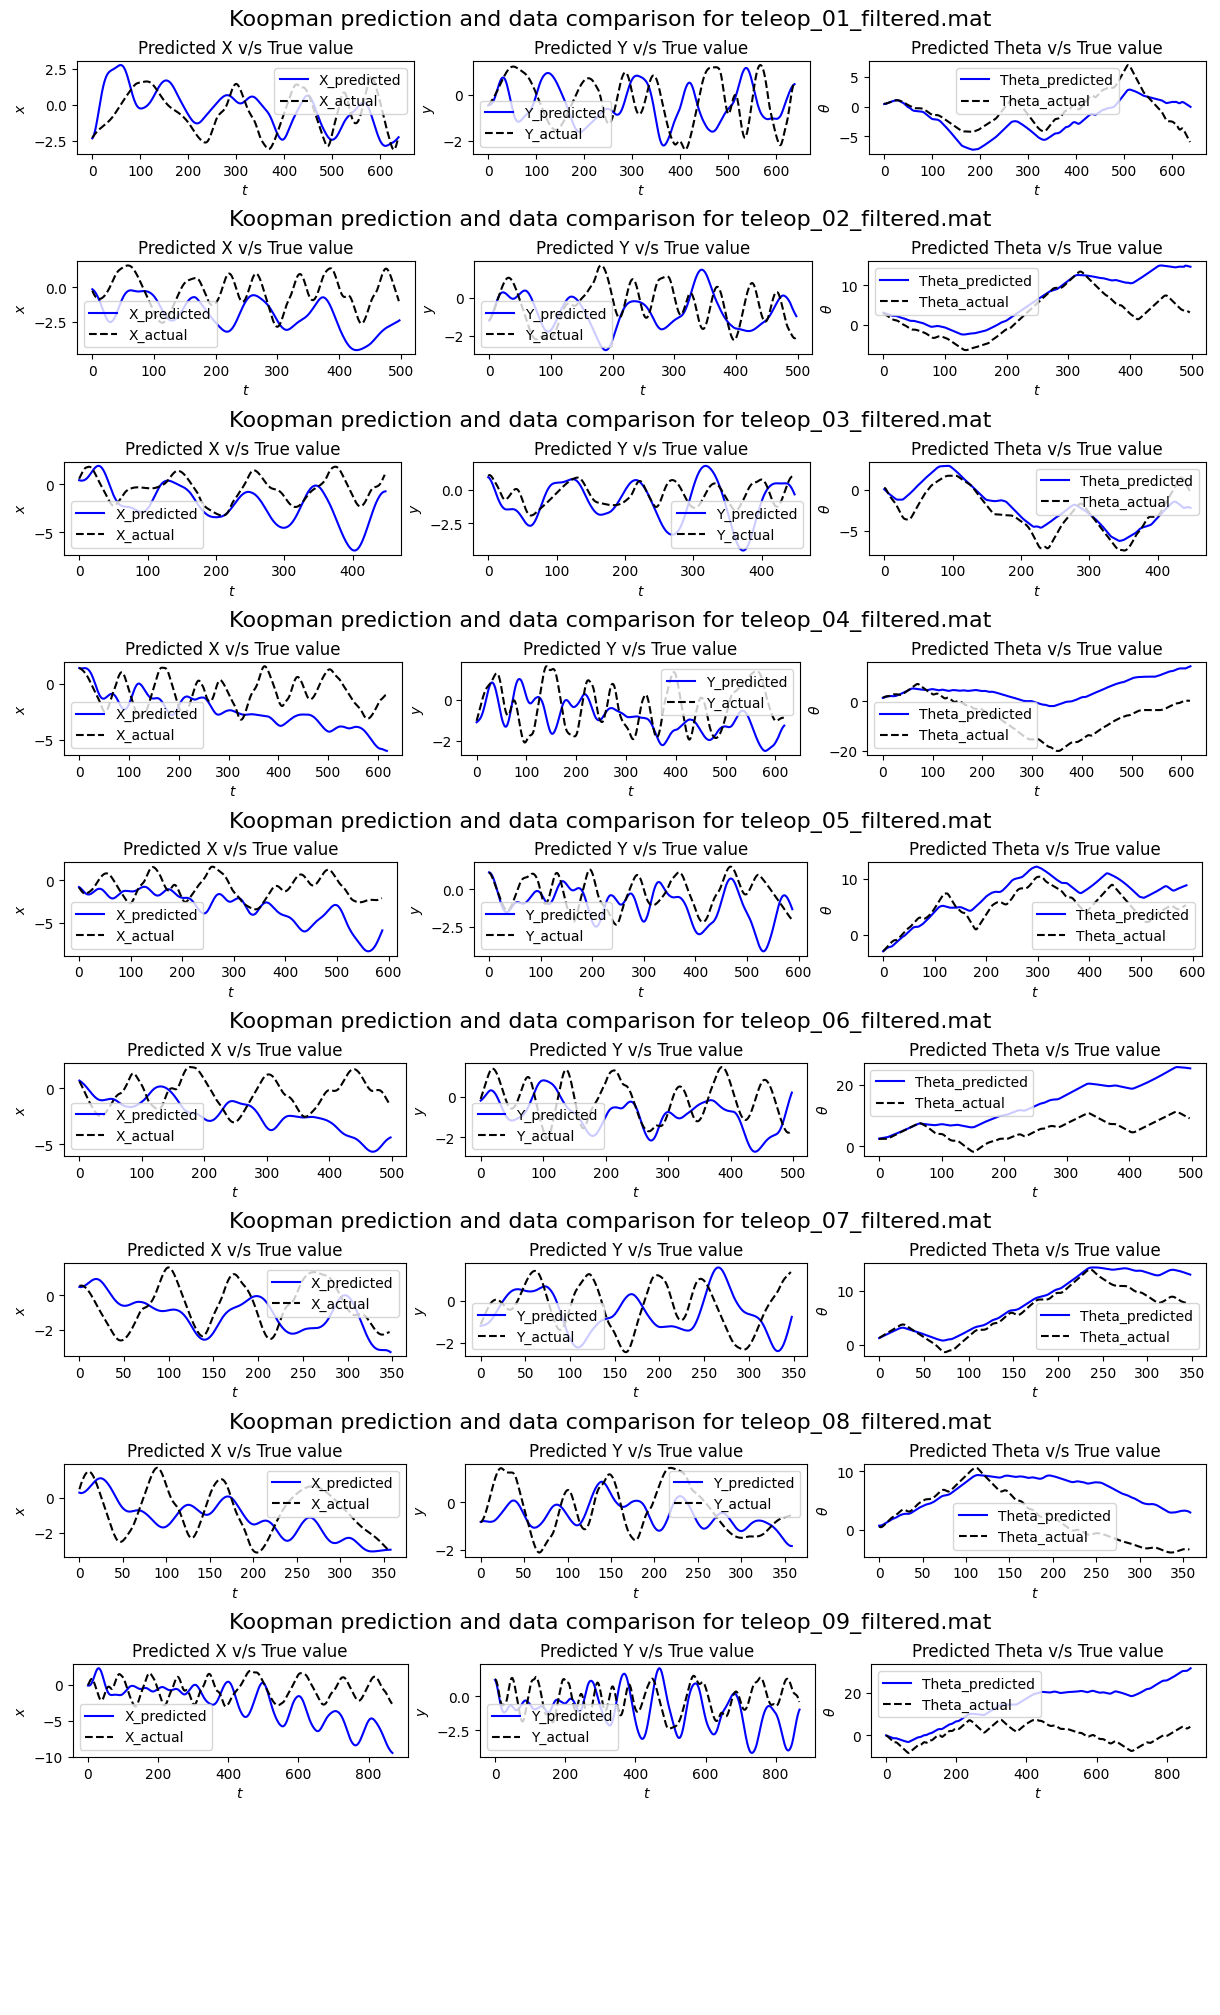

In [47]:
run_name = run_names
# imsave_name = 'Koopman_edmd_test_prediction_ol_skidpad_teleop_fishhook'
# print(X_test[5].shape)
plotter_tools_ol.plot_lifted_predictions(X_test,A_edmd_fro,B_edmd_fro,U_test,run_name)

[2] teleop_03_filtered.mat


Loading...: 100%|██████████| 378/378 [01:56<00:00,  3.24it/s]


(4, 449)
(4, 449)


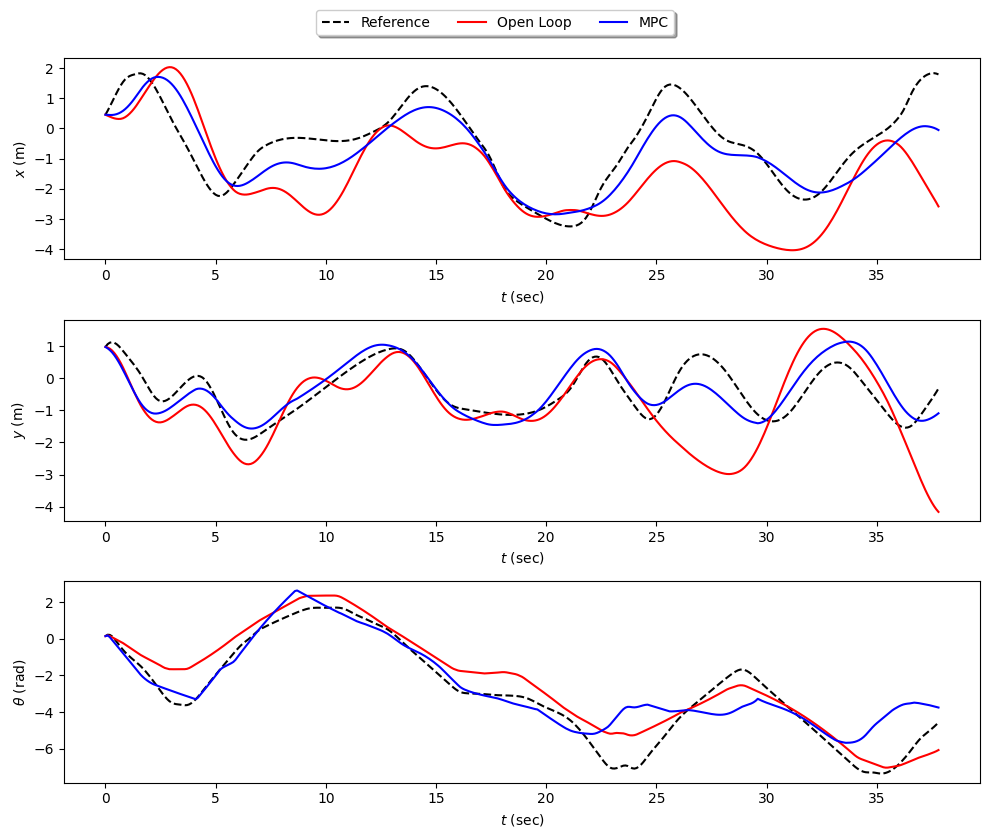

In [48]:
# Linear MPC with cvxpy
import cvxpy as cp
from cvxpy import reshape
from cvxopt import matrix
from tqdm import tqdm
import time
from pprint import pprint
import numpy as np

num = np.random.randint(0,len(X_test),1)
num = [2]
save_fig = 'No'
print(num,run_names[num[0]])
# pprint(A_edmd_fro)
test = A_edmd_fro

# Initialization
x_ref = X_test[num[0]]
z_ref = lift_states.lift_states(x_ref)
# print('Zref:',z_ref[:,1])
u_ref = U_test[num[0]].T
N = 70 # Prediction horizon

z_init = np.zeros((z_ref.shape[0],z_ref.shape[1]))
z_init[:, 0] = z_ref[:,0]
# z_init[:,0] = z_ref[:,0]

u_mpc = np.zeros((u_ref.shape[0],u_ref.shape[1]))


Q = np.zeros((z_ref.shape[0],z_ref.shape[0]))
R = np.eye(2)
Q[1,1] = 5; Q[2,2] = 5; Q[3,3] = 1; Q[4,4] = 1
umin = np.array([0,-0.75]).reshape(2)
umax = np.array([3,0.75]).reshape(2)
count = 1
time_count = []


for count in tqdm(range(1,z_ref.shape[1] - N),desc="Loading..."): # Main loop for solver
    z_pred = cp.Variable((z_ref.shape[0], N + 1))
    u_pred = cp.Variable((u_ref.shape[0], N))
    z_ref_ = matrix(z_ref[:,count:count+N+1]) # z_ref_ is the reference window for the current iteration of the loop
    u_ref_ = matrix(u_ref[:,count-1:count+N])
    # print(z_ref_.shpe,u_ref_.shape)
    cost = 0 # Initializing cost before the loop
    constr = [] # Initializing constraint value

    # constr = [z_pred[:, 0] == z_init[:,count-1]]
    for i in range(N):
        # cost += cp.quad_form(reshape(z_pred[:,i+1],(z_ref.shape[0],1)) - z_ref_[:,i],Q)  # Quad prog required to do (x-x_ref).T@Q@(x-x_ref)
        # constr += [z_pred[:, i + 1] == A_edmd @ z_pred[:, i] + B_edmd @ u_pred[:, i],umin <=u_pred[:,i], u_pred[:,i]<= umax]
        if i == 0:
            cost += cp.quad_form(reshape(z_pred[:,i+1],(z_ref.shape[0],1)) - z_ref_[:,i],Q) # Quad prog required to do (x-x_ref).T@Q@(x-x_ref)
            constr += [z_pred[:, i + 1] == A_edmd_fro @ z_pred[:, i] + B_edmd_fro @ u_pred[:, i],umin <=u_pred[:,i], u_pred[:,i]<= umax]
        else:
            cost += cp.quad_form(reshape(z_pred[:,i+1],(z_ref.shape[0],1)) - z_ref_[:,i],Q) \
                    # + cp.quad_form(reshape((u_pred[:,i]-u_pred[:,i-1])/0.5,(2,1)) ,np.eye(2)*5) # Quad prog required to do (x-x_ref).T@Q@(x-x_ref)
            constr += [z_pred[:, i + 1] == A_edmd_fro @ z_pred[:, i] + B_edmd_fro @ u_pred[:, i],umin <=u_pred[:,i], u_pred[:,i]<= umax]

    constr += [z_pred[:, 0] == z_init[:,count-1]]
    problem = cp.Problem(cp.Minimize(cost), constr)
    problem.solve(solver=cp.SCS,verbose=False)
    # print(problem.solve())
    u_mpc[:,count-1] = u_pred.value[:,0]
    z_init[:,count] = A_edmd_fro@z_init[:,count-1] + B_edmd_fro@u_pred.value[:,0]
    # z_init[:,count] = reshape(z_ref_[:,0],(15,1))
    # count += 1
    # t1 = time.time()
    # t_diff = t1-t0
    # time_count.append(t_diff)


# plt.plot(time_count)
# print(u_mpc.shape)
#Get open loop response
x_hat_ol = simulate_ol(A_edmd_fro,B_edmd_fro,C_edmd,X_test[num[0]],U_test[num[0]])
print(x_hat_ol.shape)


import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 15

# plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
# plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
# plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

x_ts = np.arange(0, len(X_test[num[0]][:-N,0]),1)
x_ts = x_ts/10

#Plot all
fig, axs = plt.subplots(3, 1, tight_layout=True, figsize=(10, 8))
# axs[0].plot(y[4,:], '--r')
axs[0].plot(x_ts,X_test[num[0]][:-N,0],'--k', label='x_ref')
axs[0].plot(x_ts,x_hat_ol[0,:-N],'r',label='X ol')
axs[0].plot(x_ts,z_init[1,:-N],'b',label='X ')

axs[0].set(ylabel=r'$x$ (m)',xlabel=r'$t$ (sec)')
# axs[0].xaxis.set_major_formatter(ticks_x)
# axs[0].legend(['x_ref','x_mpc','X_ol'],bbox_to_anchor=(1.04, 1))

# test = np.arange(0,X_test[num[0]].shape[0])
# print(test)
axs[1].plot(x_ts,X_test[num[0]][:-N,1],'--k', label='Y actual')
axs[1].plot(x_ts,x_hat_ol[1,:-N],'r',label='Y ol')
axs[1].plot(x_ts,z_init[2,:-N],'b',label='Y mpc')
axs[1].set(ylabel=r'$y$ (m)',xlabel=r'$t$ (sec)')

axs[2].plot(x_ts,X_test[num[0]][:-N,3],'--k', label='Theta actual')
axs[2].plot(x_ts,x_hat_ol[3,:-N],'r',label='Theta ol')
axs[2].plot(x_ts,z_init[4,:-N],'b',label='Theta mpc')
axs[2].set(ylabel=r'$\theta$ (rad)',xlabel=r'$t$ (sec)')
fig.legend(['Reference','Open Loop','MPC'],loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True,)
file_name_strp = run_names[num[0]].split('.')
if save_fig == 'Yes':
    plt.savefig(file_name_strp[0]+'_plots', bbox_inches='tight')
    print('Figure_saved')
plt.show()

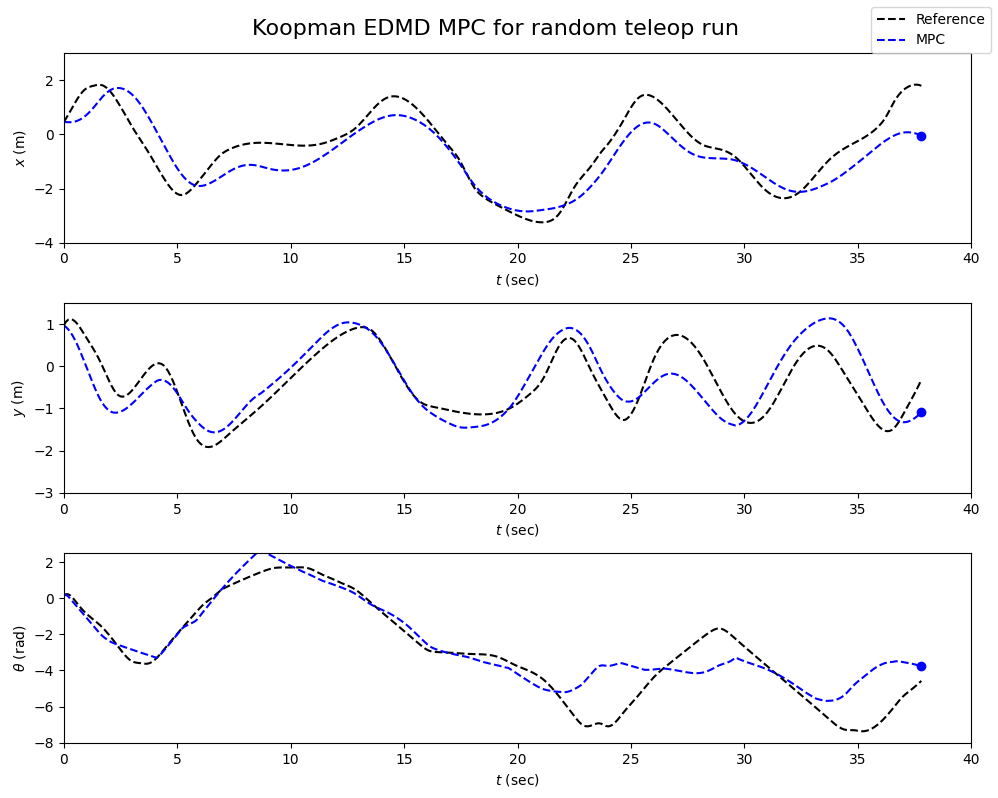

In [49]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegWriter

# This needs to be changed for your code
plt.rcParams['animation.ffmpeg_path'] = 'D:\Koopman_F1tenth\\ffmpeg\\bin\\ffmpeg.exe'

# This is the final example I showed in the code - notice I have 2 "cursor marks" not shown in the video
fig, axs = plt.subplots(3, 1, tight_layout=True, figsize=(10, 8))
axs[0].plot(x_ts,X_test[num[0]][:-N,0],'--k', label='x_ref')
axs[1].plot(x_ts,X_test[num[0]][:-N,1],'--k', label='y_ref')
axs[2].plot(x_ts,X_test[num[0]][:-N,3],'--k', label='theta_ref')
l, = axs[0].plot([], [], 'b--')
l2, = axs[1].plot([], [], 'b--')
l3, = axs[2].plot([], [], 'b--')
p1, = axs[0].plot([], [], 'bo')
p2, = axs[1].plot([], [], 'bo')
p3, = axs[2].plot([], [], 'bo')
axs[0].set(ylabel=r'$x$ (m)',xlabel=r'$t$ (sec)')
axs[1].set(ylabel=r'$y$ (m)',xlabel=r'$t$ (sec)')
axs[2].set(ylabel=r'$\theta$ (rad)',xlabel=r'$t$ (sec)')
# plt.xlabel('xlabel')
# plt.ylabel('ylabel')
# plt.title('title')
#
axs[0].axis(xmin=0,xmax=40)
axs[0].axis(ymin=-4,ymax=3)
axs[1].axis(xmin=0,xmax=40)
axs[1].axis(ymin=-3,ymax=1.5)
axs[2].axis(xmin=0,xmax=40)
axs[2].axis(ymin=-8,ymax=2.5)
fig.legend(['Reference', 'MPC'],loc='upper right')
fig.suptitle('Koopman EDMD MPC for random teleop run', fontsize=16)



def func(x):
    return np.sin(x)*3

def func2(x):
    return np.cos(x)*3

metadata = dict(title='Movie', artist='codinglikemad')
writer = FFMpegWriter(fps=15, metadata=metadata)


xlist = []

ylist = []
ylist2 = []
ylist3 = []


with writer.saving(fig, "EDMD_Koopman_MPC_teleop.mp4", 250):

    # Plot the first line and cursor
    for i in range(len(x_ts)):
        xlist.append(x_ts[i])
        ylist.append(z_init[1,i])
        l.set_data(xlist,ylist)
        p1.set_data(x_ts[i],z_init[1,i])

        # xlist.append(x_ts[i])
        ylist2.append(z_init[2,i])
        l2.set_data(xlist,ylist2)
        p2.set_data(x_ts[i],z_init[2,i])

        # xlist3.append(x_ts[i])
        ylist3.append(z_init[4,i])
        l3.set_data(xlist,ylist3)
        p3.set_data(x_ts[i],z_init[4,i])

        writer.grab_frame()